<a href="https://colab.research.google.com/github/motoroko/machinelearning/blob/master/TUBESMALIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering



 Import Library

In [0]:
import numpy as np 
import pandas as pd
import io
import random
import math
from google.colab import files
import matplotlib.pyplot as plt
from scipy.spatial import distance
from collections import Counter

 Import Dataset

In [6]:
uploaded = files.upload()

Saving air_bnb.csv to air_bnb (3).csv


 Dataset Preprocessing

In [5]:
df = pd.read_csv(io.BytesIO(uploaded['air_bnb.csv']))
df.shape

(22552, 16)

In [6]:
df.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2015,Berlin-Mitte Value! Quiet courtyard/very central,2217,Ian,Mitte,Brunnenstr. Süd,52.534537,13.402557,Entire home/apt,60,4,118,2018-10-28,3.76,4,141
1,2695,Prenzlauer Berg close to Mauerpark,2986,Michael,Pankow,Prenzlauer Berg Nordwest,52.548513,13.404553,Private room,17,2,6,2018-10-01,1.42,1,0
2,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.534996,13.417579,Entire home/apt,90,62,143,2017-03-20,1.25,1,220
3,3309,BerlinSpot Schöneberg near KaDeWe,4108,Jana,Tempelhof - Schöneberg,Schöneberg-Nord,52.498855,13.349065,Private room,26,5,25,2018-08-16,0.39,1,297
4,7071,BrightRoom with sunny greenview!,17391,Bright,Pankow,Helmholtzplatz,52.543157,13.415091,Private room,42,2,197,2018-11-04,1.75,1,26


In [9]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,2.255200e+04,2.255200e+04,22552.000000,22552.000000,22552.000000,22552.000000,22552.000000,18638.000000,22552.000000,22552.000000
mean,1.571560e+07,5.403355e+07,52.509824,13.406107,67.143668,7.157059,17.840679,1.135525,1.918233,79.852829
std,8.552069e+06,5.816290e+07,0.030825,0.057964,220.266210,40.665073,36.769624,1.507082,3.667257,119.368162
min,2.015000e+03,2.217000e+03,52.345803,13.103557,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,8.065954e+06,9.240002e+06,52.489065,13.375411,30.000000,2.000000,1.000000,0.180000,1.000000,0.000000
50%,1.686638e+07,3.126711e+07,52.509079,13.416779,45.000000,2.000000,5.000000,0.540000,1.000000,4.000000
75%,2.258393e+07,8.067518e+07,52.532669,13.439259,70.000000,4.000000,16.000000,1.500000,1.000000,129.000000
max,2.986735e+07,2.245081e+08,52.651670,13.757642,9000.000000,5000.000000,498.000000,36.670000,45.000000,365.000000


In [7]:
dfclust,classes = pd.DataFrame(data=[]),pd.DataFrame(data=[])
dfclust['neighbourhood'] = df['neighbourhood'] 
dfclust['number_of_reviews'] = df['number_of_reviews']
classes['class'] = np.zeros((dfclust.shape[0]))
dfclust

,neighbourhood,number_of_reviews
0,Brunnenstr. Süd,118
1,Prenzlauer Berg Nordwest,6
2,Prenzlauer Berg Südwest,143
3,Schöneberg-Nord,25
4,Helmholtzplatz,197
...,...,...
22547,Brunnenstr. Süd,0
22548,Schöneberg-Nord,0
22549,Prenzlauer Berg Südwest,0
22550,Alexanderplatz,0


Missing Value Problem

In [18]:
# Checking the size of the row with complete value
a = dfclust.dropna()
print(a.shape)
print( np.round((a.shape[0]/dfclust.shape[0]) * 100,2), '%') 

(22552, 2)
100.0 %


In [19]:
# Checking the size of the row with missing value
a = dfclust[dfclust.isnull().any(axis='columns')]
print(a.shape[0])
print( np.round((a.shape[0]/dfclust.shape[0]) * 100,2), '%') 

0
0.0 %


Categorical Encoding

In [23]:
def delduplicate(a):
  b = a
  return list(Counter(b))

key = []

for i in dfclust.columns:
  key.append(delduplicate(dfclust[i]))

for i in range(len(dfclust.columns)):
  if dfclust[dfclust.columns[i]].dtypes != 'int64' and dfclust[dfclust.columns[i]].dtypes != 'float64':
    for j in range(len(dfclust)):
      k = key[i]
      for l in range(len(k)):
        if dfclust[dfclust.columns[i]].iloc[j] == k[l]:
          dfclust[dfclust.columns[i]].iloc[j] = l+1
          break

dfclust

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,neighbourhood,number_of_reviews
0,1,118
1,2,6
2,3,143
3,4,25
4,5,197
...,...,...
22547,1,0
22548,4,0
22549,3,0
22550,17,0


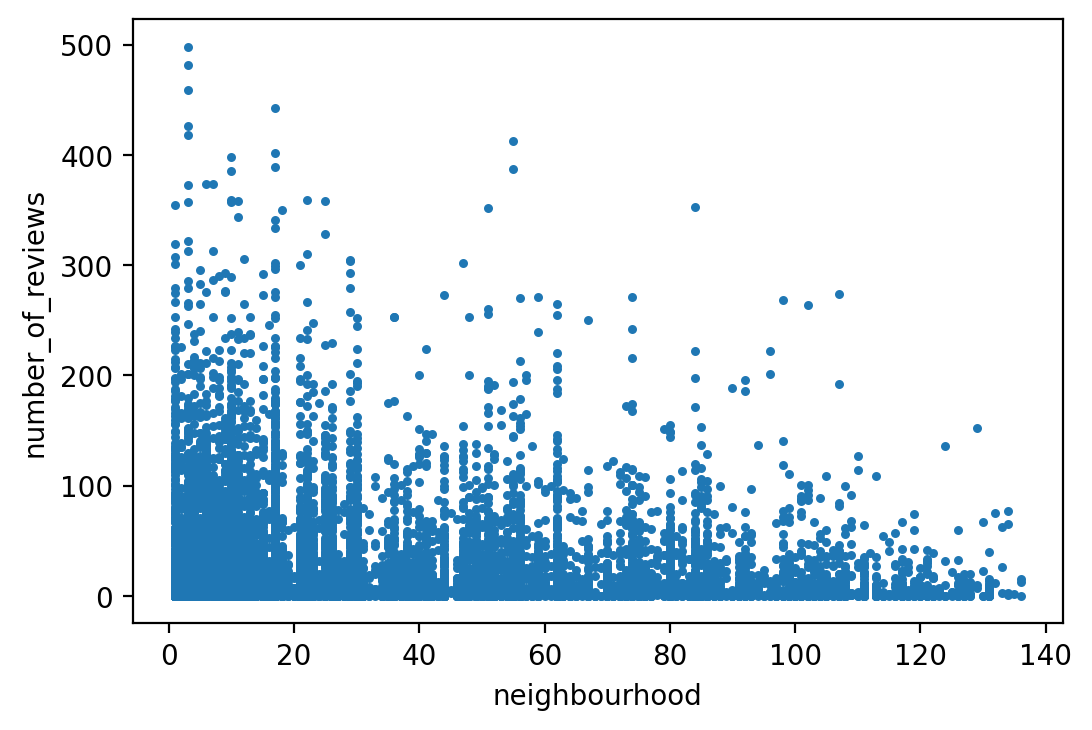

In [24]:
plt.figure(dpi=200)
plt.scatter(dfclust['neighbourhood'],dfclust['number_of_reviews'],s=5)
plt.xlabel('neighbourhood')
plt.ylabel('number_of_reviews')
plt.show()

MinMax Scalling

In [25]:
for i in dfclust.columns:
  for j in range(len(dfclust[i])):
    dfclust[i].iloc[j] = ( dfclust[i].iloc[j] - min(dfclust[i]) ) / ( max(dfclust[i]) - min(dfclust[i]) )

dfclust

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,neighbourhood,number_of_reviews
0,0,0.236948
1,0.0147059,0.012048
2,0.0220588,0.287149
3,0.0294118,0.050201
4,0.0367647,0.395582
...,...,...
22547,0.0588235,0.000000
22548,0.235294,0.000000
22549,0.176471,0.000000
22550,1,0.000000


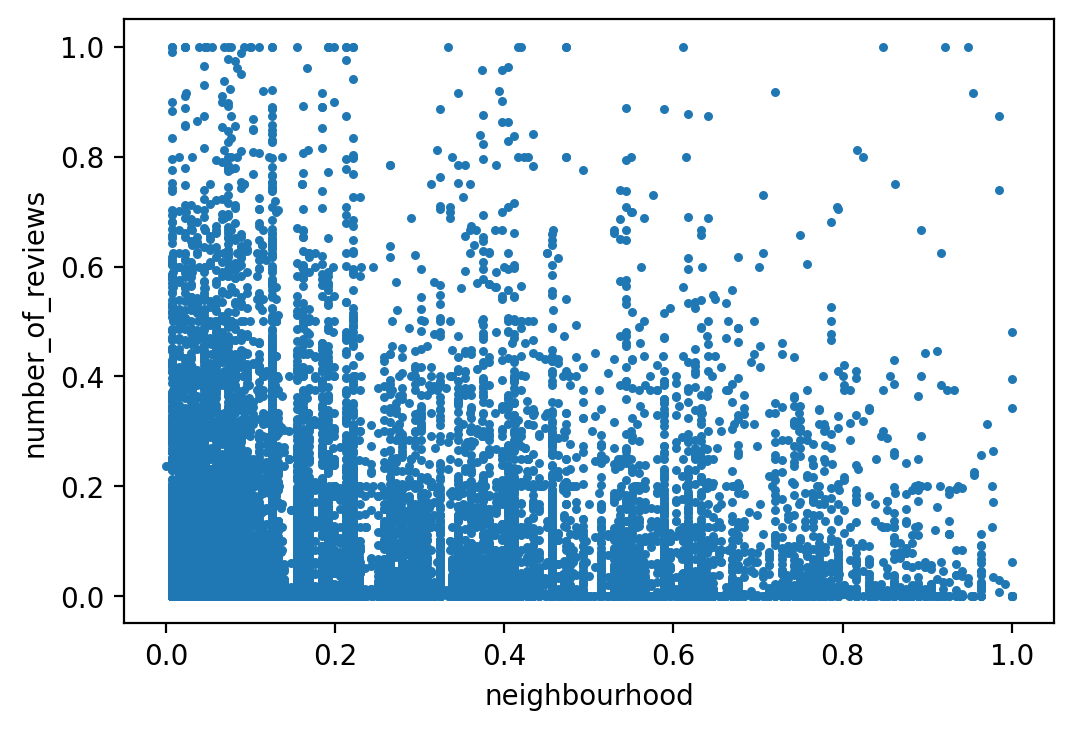

In [26]:
plt.figure(dpi=200)
plt.scatter(dfclust['neighbourhood'],dfclust['number_of_reviews'],s=5)
plt.xlabel('neighbourhood')
plt.ylabel('number_of_reviews')
plt.show()

 Elbow Method

In [0]:
numberOfK , distortions = [],[]

for entity in range(2,16):
  k = entity

  df1 = dfclust['neighbourhood']
  df2 = dfclust['number_of_reviews']

  newX , newY = [],[]

  for i in range(k):
    newX.append(df1.sample().values)
    newY.append(df2.sample().values)
  
  df3 = pd.Series(newX)
  df4 = pd.Series(newY)

  newCentroidX = newX
  newCentroidY = newY

  same = False
  while ( not same ):
    zonex,zoney = [],[]
    for i in range(k):
      zonex.append([])
      zoney.append([])

    x1 = newCentroidX
    y1 = newCentroidY

    for i in range(len(df1)):
      dist = []
      for j in range(k):
        dist.append(math.sqrt(((x1[j] - df1.iloc[i])**2) + ((y1[j] - df2.iloc[i])**2)))

      for j in range(len(dist)):
        if dist[j] == min(dist):
          zonex[j].append(df1.iloc[i])
          zoney[j].append(df2.iloc[i])
          break

    newCentroidX,newCentroidY = [],[]

    #new centroid
    for i in range(k):
      newCentroidX.append(sum(zonex[i])/len(zonex[i]))
      newCentroidY.append(sum(zoney[i])/len(zonex[i]))

    df3 = pd.Series(newCentroidX)
    df4 = pd.Series(newCentroidY)

    for i in range(k):
      if newCentroidX[i] == x1[i] and newCentroidY[i] == y1[i]:
        same = True

  centers = np.array(list(zip(df3, df4))).reshape(len(df3), 2)
  distortions.append(sum(np.min(distance.cdist(dfclust, centers, 'euclidean'), axis=1)) / centers.shape[0])
  numberOfK.append(k)


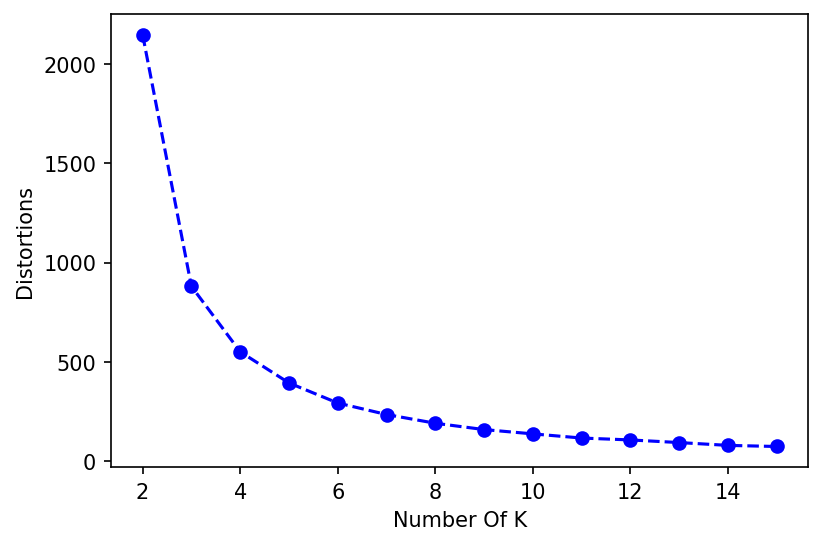

In [28]:
plt.figure(dpi=150)
plt.plot(numberOfK,distortions, 'bo--')
plt.xlabel('Number Of K')
plt.ylabel('Distortions')
plt.show()

In [32]:
elbow = pd.DataFrame(data=[])
elbow['k'] = numberOfK
elbow['distortions'] = distortions

elbow

,k,distortions
0,2,2146.564240
1,3,880.102758
2,4,550.902700
3,5,394.008373
4,6,292.929574
5,7,235.057984
6,8,191.100096
7,9,159.250360
8,10,137.575688
9,11,116.642444


Cluster with centroid randomly pick array sample

K Value is  3


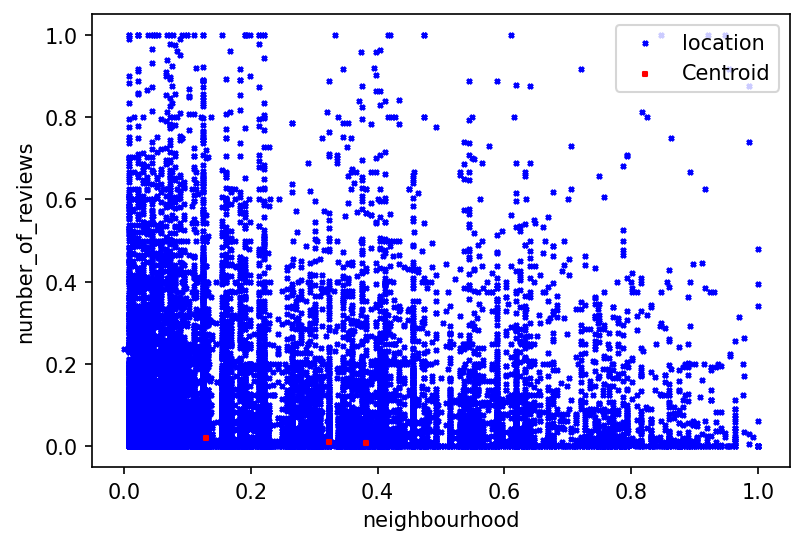

start looping


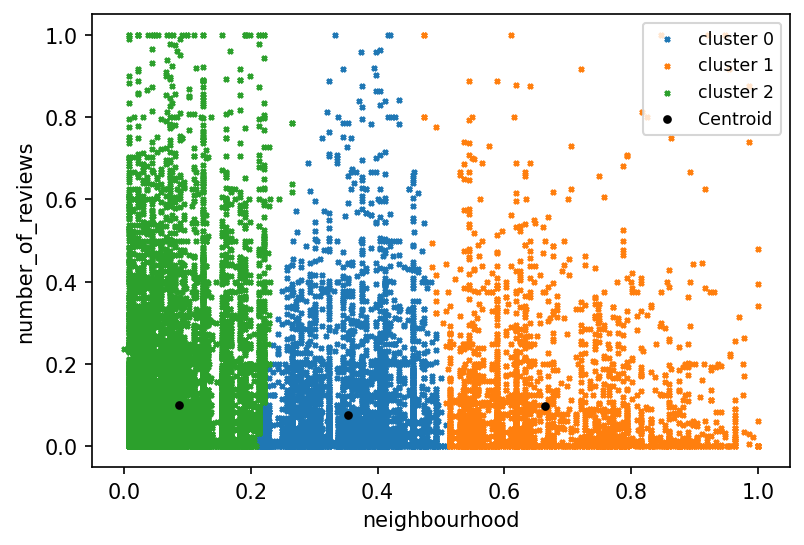

end looping


In [39]:
k = 3

print('K Value is ', k)

df1 = dfclust['neighbourhood']
df2 = dfclust['number_of_reviews']

newX , newY = [],[]

for i in range(k):
  newX.append(df1.sample().values)
  newY.append(df2.sample().values)

df3 = pd.Series(newX)
df4 = pd.Series(newY)

plt.figure(dpi=150)
plt.scatter(df1,df2,c='b',marker='x',label='location',s=5)
plt.scatter(df3,df4,c='r',marker='s',label='Centroid',s=5)
plt.xlabel('neighbourhood')
plt.ylabel('number_of_reviews')
plt.legend()
plt.show()

newCentroidX = newX
newCentroidY = newY

same = False

print("start looping")
while ( not same ):
  zonex,zoney = [],[]
  for i in range(k):
    zonex.append([])
    zoney.append([])

  x1 = newCentroidX
  y1 = newCentroidY

  for i in range(len(df1)):
    dist = []
    for j in range(k):
      dist.append(math.sqrt(((x1[j] - df1.iloc[i])**2) + ((y1[j] - df2.iloc[i])**2)))

    for j in range(len(dist)):
      if dist[j] == min(dist):
        classes['class'].iloc[i] = j+1
        zonex[j].append(df1.iloc[i])
        zoney[j].append(df2.iloc[i])
        break

  newCentroidX,newCentroidY = [],[]

  #new centroid
  for i in range(k):
    newCentroidX.append(sum(zonex[i])/len(zonex[i]))
    newCentroidY.append(sum(zoney[i])/len(zonex[i]))

  df3 = pd.Series(newCentroidX)
  df4 = pd.Series(newCentroidY)

  for i in range(k):
    if newCentroidX[i] == x1[i] and newCentroidY[i] == y1[i]:
      same = True

plt.figure(dpi=150)
for i in range(k):
  plt.scatter(zonex[i],zoney[i],marker='x',label='cluster '+str(i),s=5)
plt.scatter(df3,df4,c='black',label='Centroid',s=10)
plt.xlabel('neighbourhood')
plt.ylabel('number_of_reviews')
plt.legend(fontsize='small')
plt.show()

print("end looping")

Cluster with centroid use random number in between min and max value of each array

K Value is  3


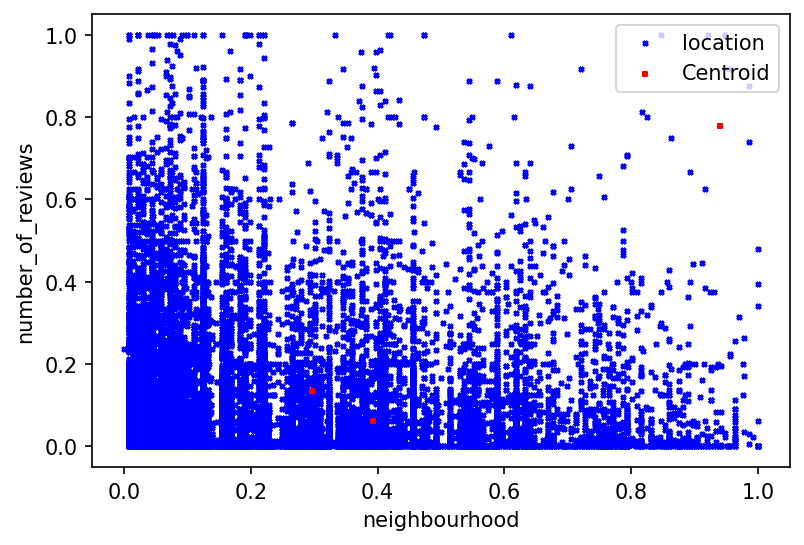

start looping


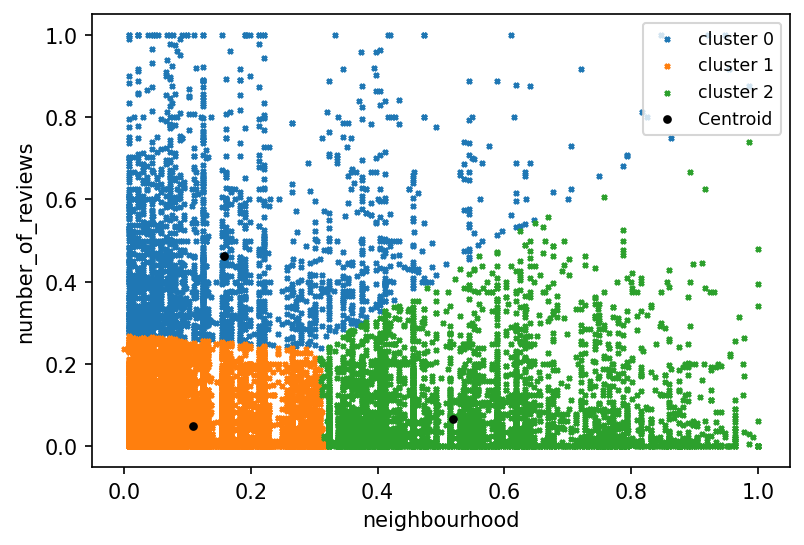

end looping


In [40]:
k = 3

print('K Value is ', k)

df1 = dfclust['neighbourhood']
df2 = dfclust['number_of_reviews']

newX , newY = [],[]

for i in range(k):
  newX.append(random.uniform(min(df1),max(df1)))
  newY.append(random.uniform(min(df2),max(df2)))

df3 = pd.Series(newX)
df4 = pd.Series(newY)

plt.figure(dpi=150)
plt.scatter(df1,df2,c='b',marker='x',label='location',s=5)
plt.scatter(df3,df4,c='r',marker='s',label='Centroid',s=5)
plt.xlabel('neighbourhood')
plt.ylabel('number_of_reviews')
plt.legend()
plt.show()

newCentroidX = newX
newCentroidY = newY

same = False

print("start looping")
while ( not same ):
  zonex,zoney = [],[]
  for i in range(k):
    zonex.append([])
    zoney.append([])

  x1 = newCentroidX
  y1 = newCentroidY

  for i in range(len(df1)):
    dist = []
    for j in range(k):
      dist.append(math.sqrt(((x1[j] - df1.iloc[i])**2) + ((y1[j] - df2.iloc[i])**2)))

    for j in range(len(dist)):
      if dist[j] == min(dist):
        classes['class'].iloc[i] = j+1
        zonex[j].append(df1.iloc[i])
        zoney[j].append(df2.iloc[i])
        break

  newCentroidX,newCentroidY = [],[]

  #new centroid
  for i in range(k):
    newCentroidX.append(sum(zonex[i])/len(zonex[i]))
    newCentroidY.append(sum(zoney[i])/len(zonex[i]))
    
  df3 = pd.Series(newCentroidX)
  df4 = pd.Series(newCentroidY)

  for i in range(k):
    if newCentroidX[i] == x1[i] and newCentroidY[i] == y1[i]:
      same = True

plt.figure(dpi=150)
for i in range(k):
  plt.scatter(zonex[i],zoney[i],marker='x',label='cluster '+str(i),s=5)
plt.scatter(df3,df4,c='black',label='Centroid',s=10)
plt.xlabel('neighbourhood')
plt.ylabel('number_of_reviews')
plt.legend(fontsize='small')
plt.show()

print("end looping")

# Classification

Import library

In [0]:
%matplotlib inline

from sklearn import preprocessing, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tensorflow.keras import layers
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler 
from matplotlib.colors import ListedColormap

In [7]:
df = pd.read_csv(io.BytesIO(uploaded['air_bnb.csv']))
df.shape

(22552, 16)

In [8]:
df2 = df[['neighbourhood','price','room_type']]
df2

,neighbourhood,price,room_type
0,Brunnenstr. Süd,60,Entire home/apt
1,Prenzlauer Berg Nordwest,17,Private room
2,Prenzlauer Berg Südwest,90,Entire home/apt
3,Schöneberg-Nord,26,Private room
4,Helmholtzplatz,42,Private room
...,...,...,...
22547,Brunnenstr. Süd,60,Entire home/apt
22548,Schöneberg-Nord,20,Shared room
22549,Prenzlauer Berg Südwest,85,Entire home/apt
22550,Alexanderplatz,99,Private room


In [9]:
def delduplicate(a):
  b = a
  return list(Counter(b))

key = []

for i in df2.columns:
  key.append(delduplicate(df2[i]))

for i in range(len(df2.columns)):
  if df2[df2.columns[i]].dtypes != 'int64' and df2[df2.columns[i]].dtypes != 'float64':
    for j in range(len(df2)):
      k = key[i]
      for l in range(len(k)):
        if df2[df2.columns[i]].iloc[j] == k[l]:
          df2[df2.columns[i]].iloc[j] = l+1
          break

df2

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,neighbourhood,price,room_type
0,1,60,1
1,2,17,2
2,3,90,1
3,4,26,2
4,5,42,2
...,...,...,...
22547,1,60,1
22548,4,20,3
22549,3,85,1
22550,17,99,2


In [0]:
clean_data = df2.to_numpy()

In [11]:
train, test = train_test_split(clean_data, test_size=0.2)
print(len(train), 'train examples')
print(len(test), 'test examples')

18041 train examples
4511 test examples


In [0]:
train_data = np.copy(train)
test_data = np.copy(test)
y_train = train[:,-1]
X_train = train_data[:,:-1]
y_test = test[:,-1]
x_test = test_data[:,:-1]
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [0]:
st_x= StandardScaler()    
X_train= st_x.fit_transform(X_train)    
x_test= st_x.transform(x_test)

KNN Classifier

In [16]:
classifier= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [17]:
y_pred = classifier.predict(x_test)
print(y_pred)

[1 2 1 ... 2 1 2]


In [19]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1629  528    0]
 [ 567 1731    6]
 [  14   27    9]]
              precision    recall  f1-score   support

           1       0.74      0.76      0.75      2157
           2       0.76      0.75      0.75      2304
           3       0.60      0.18      0.28        50

    accuracy                           0.75      4511
   macro avg       0.70      0.56      0.59      4511
weighted avg       0.75      0.75      0.75      4511



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


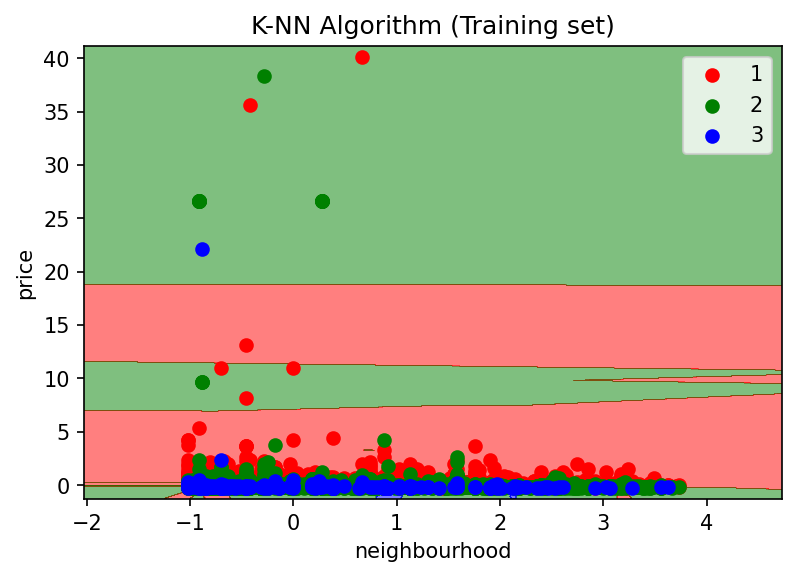

In [54]:
#Visulaizing the training set result  
plt.figure(dpi=150)
x_set, y_set = X_train, y_train  
x1, x2 = np.meshgrid(np.arange(start = x_set[:, 0].min() - 1, stop = x_set[:, 0].max() + 1, step  =0.01),  
np.arange(start = x_set[:, 1].min() - 1, stop = x_set[:, 1].max() + 1, step = 0.01))  
plt.contourf(x1, x2, classifier.predict(np.array([x1.ravel(), x2.ravel()]).T).reshape(x1.shape),  
alpha = 0.5, cmap = ListedColormap(('red','green','blue' )))
plt.xlim(x1.min(), x1.max())  
plt.ylim(x2.min(), x2.max())  
for i, j in enumerate(np.unique(y_set)):  
    plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1],  
        c = ListedColormap(('red', 'green','blue'))(i), label = j)  
plt.title('K-NN Algorithm (Training set)')  
plt.xlabel('neighbourhood')  
plt.ylabel('price')  
plt.legend()  
plt.show()  

SVM Classifier

In [0]:
train_data = np.copy(train)
test_data = np.copy(test)
y_train = train[:,-1]
X_train = train_data[:,:-1]
y_test = test[:,-1]
x_test = test_data[:,:-1]
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [0]:
st_x= StandardScaler()    
X_train= st_x.fit_transform(X_train)    
x_test= st_x.transform(x_test)

In [22]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1088 1069    0]
 [ 191 2113    0]
 [   8   42    0]]
              precision    recall  f1-score   support

           1       0.85      0.50      0.63      2157
           2       0.66      0.92      0.76      2304
           3       0.00      0.00      0.00        50

    accuracy                           0.71      4511
   macro avg       0.50      0.47      0.47      4511
weighted avg       0.74      0.71      0.69      4511



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Gaussian Kernel

In [0]:
train_data = np.copy(train)
test_data = np.copy(test)
y_train = train[:,-1]
X_train = train_data[:,:-1]
y_test = test[:,-1]
x_test = test_data[:,:-1]
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [0]:
st_x= StandardScaler()    
X_train= st_x.fit_transform(X_train)    
x_test= st_x.transform(x_test)

In [16]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1465  663    0]
 [ 397 1921    0]
 [  10   55    0]]
              precision    recall  f1-score   support

           1       0.78      0.69      0.73      2128
           2       0.73      0.83      0.78      2318
           3       0.00      0.00      0.00        65

    accuracy                           0.75      4511
   macro avg       0.50      0.51      0.50      4511
weighted avg       0.74      0.75      0.74      4511



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Sigmoid Kernel

In [0]:
train_data = np.copy(train)
test_data = np.copy(test)
y_train = train[:,-1]
X_train = train_data[:,:-1]
y_test = test[:,-1]
x_test = test_data[:,:-1]
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [0]:
st_x= StandardScaler()    
X_train= st_x.fit_transform(X_train)    
x_test= st_x.transform(x_test)

In [19]:
svclassifier = SVC(kernel='sigmoid')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1144  984    0]
 [ 963 1355    0]
 [  32   33    0]]
              precision    recall  f1-score   support

           1       0.53      0.54      0.54      2128
           2       0.57      0.58      0.58      2318
           3       0.00      0.00      0.00        65

    accuracy                           0.55      4511
   macro avg       0.37      0.37      0.37      4511
weighted avg       0.55      0.55      0.55      4511



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
